In [ ]:
import cv2
import os
from keras.models import load_model
import numpy as np
import time
import gdown
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import mediapipe as mp

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 23.3 MB/s eta 0:00:00


In [ ]:
def predict(img_path,model,font):
  # Load the input image
  image = cv2.imread(img_path)
  height,width = image.shape[:2] 
  # Define the MediaPipe face detection and landmark detection models
  mp_face_detection = mp.solutions.face_detection
  mp_face_mesh = mp.solutions.face_mesh

  # Define a MediaPipe drawing utility to draw the landmarks on the image
  mp_drawing = mp.solutions.drawing_utils

  # Define a dictionary to map the indices of the left and right eyes
  eye_indices = {'left': [159, 145, 133, 155, 153, 154], 'right': [386, 374, 362, 380, 378, 379]}

  # Initialize the face detection and landmark detection models
  with mp_face_detection.FaceDetection() as face_detection:
    with mp_face_mesh.FaceMesh() as face_mesh:
        # Convert the input image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect the face in the image using the face detection model
        results = face_detection.process(image)

        # Check if a face was detected
        if results.detections:
            # Extract the bounding box for the face
            for detection in results.detections:
                bbox = detection.location_data.relative_bounding_box
                x, y, w, h = int(bbox.xmin * image.shape[1]), int(bbox.ymin * image.shape[0]), \
                             int(bbox.width * image.shape[1]), int(bbox.height * image.shape[0])

                # Draw a rectangle around the face
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Extract the facial landmarks using the landmark detection model
            face_landmarks = face_mesh.process(image).multi_face_landmarks

            # Loop over each face landmark
            for landmarks in face_landmarks:
                # Loop over each eye and extract the eye region
                eyes_pred_list=[]
                flipped_image = cv2.flip(image, 1)
                for eye in eye_indices:
                    eye_landmarks = [landmarks.landmark[idx] for idx in eye_indices[eye]]
                    eye_min_x = min([lm.x for lm in eye_landmarks])
                    eye_max_x = max([lm.x for lm in eye_landmarks])
                    eye_min_y = min([lm.y for lm in eye_landmarks])
                    eye_max_y = max([lm.y for lm in eye_landmarks])
                    eye_region = image[int(eye_min_y*image.shape[0]):int(eye_max_y*image.shape[0]),
                                       int(eye_min_x*image.shape[1]):int(eye_max_x*image.shape[1])]
                  
                    r_eye = cv2.resize(eye_region,(24,24))
                    r_eye = cv2.cvtColor(r_eye, cv2.COLOR_BGR2GRAY)
                    r_eye= r_eye/255
                    r_eye=  r_eye.reshape(24,24,-1)
                    r_eye = np.expand_dims(r_eye,axis=0)
                    # Preprocess the eye region for input to the CNN classifier
                    r_eye = cv2.resize(eye_region,(24,24))
                    r_eye = cv2.cvtColor(r_eye, cv2.COLOR_BGR2GRAY)
                    r_eye= r_eye/255
                    r_eye=  r_eye.reshape(24,24,-1)
                    r_eye = np.expand_dims(r_eye,axis=0)
                    

                    # Pass the preprocessed eye region to the CNN classifier and get the prediction
                    pred = model.predict(r_eye)
                    pred = np.argmax(pred, axis=1)
                    eyes_pred_list.append(pred[0])
        
        if(eyes_pred_list[0]==0 and eyes_pred_list[1]==0):
          #cv2.rectangle(image, (10, height-40), (110, height-10), (0, 0, 0), -1)
          cv2.putText(image,"Closed",(x, y+h+30), font, 1, (255, 0, 0),1,cv2.LINE_AA)
        # if(rpred[0]==1 or lpred[0]==1):
        else:
          #cv2.rectangle(image, (10, height-40), (110, height-10), (0, 0, 0), -1)
          cv2.putText(image,"Open",(x, y+h+30), font, 1,(0, 255, 0),1,cv2.LINE_AA)
        # Convert the image back to BGR format for display purposes
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # Display the output image
        return(image)

In [ ]:
model = load_model('cnn_classifier_2.h5')
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

1/1 [==============================] - 0s 33ms/step


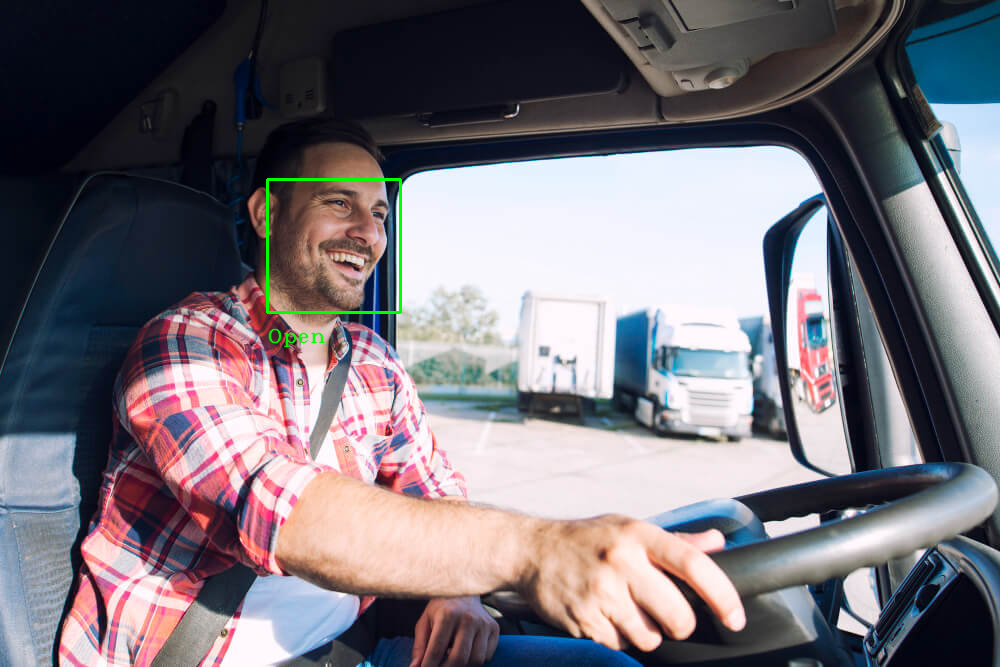

In [ ]:
img=predict('driver1.jpg',model,font)
cv2_imshow(img)

1/1 [==============================] - 0s 25ms/step


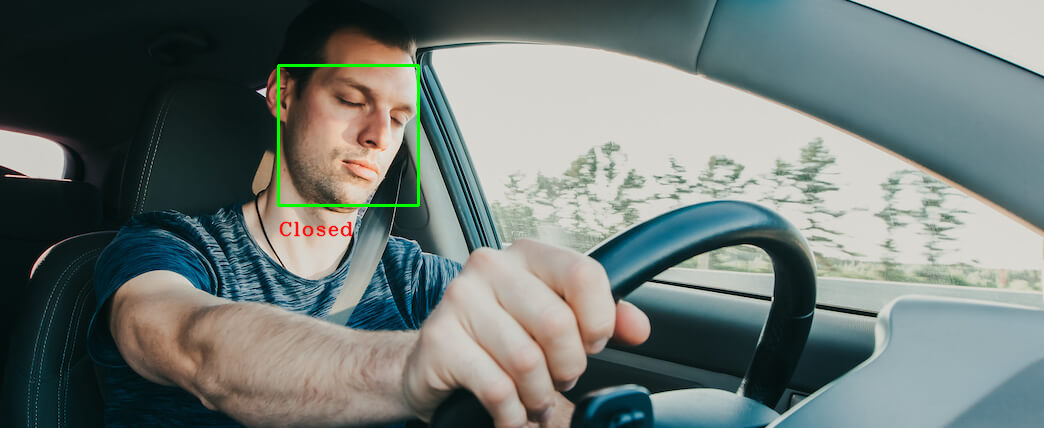

In [ ]:
img=predict('driver2.jpeg',model,font)
cv2_imshow(img)

1/1 [==============================] - 0s 23ms/step


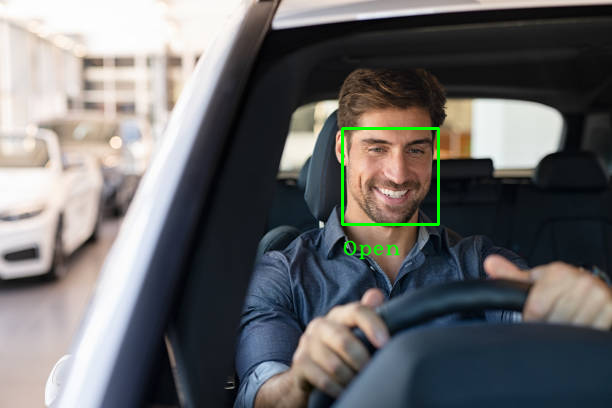

In [ ]:
img=predict('driver3.jpg',model,font)
cv2_imshow(img)